<a href="https://colab.research.google.com/github/ruhanaazam/gp_transfer/blob/main/MixedKernelTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!cd drive

In [3]:
!pip install gpytorch
!pip install botorch

In [4]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import gpytorch
from botorch.utils.transforms import normalize, standardize
import matplotlib.pyplot as plt

from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP, MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms import Standardize, Normalize
from botorch.utils.transforms import normalize, standardize
from botorch.fit import fit_gpytorch_mll
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
base_path = "/content/drive/My Drive/Colab Notebooks/Transfer_Coh2"

In [6]:
def surfacePlot(model, title = "Your Function" ,n=900):
    '''
    Plots your (true or estimated) coheritability function.
    model: function that takes in two wavelength and outputs coh2 (estimate)
    n: n**2 is the number of points to plot the surface
    '''
    # Generate data for the plot
    x1 = torch.linspace(0, 1, n)
    x2 = torch.linspace(0, 1, n)
    X1, X2 = torch.meshgrid(x1, x2)
    X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

    Z = model(X.to(device)).cpu().detach().numpy()

    # Create a contour plot
    plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis')
    plt.colorbar(label='Function Value')

    #plot top 1%
    #threshold = np.percentile(Z, 99)
    #threshold = torch.kthvalue(Z.flatten(), int(0.99 * n * n)).values
    #plt.contour(X1, X2, Z.reshape(n, n), levels=[threshold], colors='red', linewidths=2)

    # Add labels and title
    plt.xlabel('Wavelength 1')
    plt.ylabel('Wavelength 2')
    plt.title(title)

    # Show the plot
    plt.show()
    return

In [7]:
def getTaskID(trait, crop="Sorghum"):
    assert crop == "Sorghum", "Does not handles ids for from that are not Sorghum yet."
    ids = {"narea": 1, "sla": 2, "pn": 3, "ps": 4}
    return ids[trait]

In [8]:
def loadTasks(tasks):
    taskData = []
    for trait in tasks:
        #read raw task file
        data = pd.read_csv(f"{base_path}/data/{trait}_coh2.csv")
        data = torch.tensor(data.values)

        #format data for supervised training, each row : (taskid, wave1, wave2, coh2)
        n = torch.ones(data.shape[0], dtype=torch.float32)
        col_index =  torch.arange(data.shape[0], dtype=torch.float32)
        col_index = torch.outer(n, col_index)
        row_index = col_index.T

        #stack wave1, wave2 and coh2 tensors together
        task_ids = torch.ones(data.shape) * getTaskID(trait)
        flat_data = torch.stack([task_ids.flatten(), col_index.flatten(), row_index.flatten(), data.flatten()])
        flat_data = flat_data.T

        #remove all rows with nans
        nan_mask = torch.isnan(flat_data)
        nan_in_rows = torch.any(nan_mask, dim=1)
        clean = flat_data[~nan_in_rows]

        taskData.append(clean)

    #combine all tasks data into a tensor
    all_tasks = torch.cat(taskData)
    return all_tasks[:, :3], all_tasks[:, -1]

In [9]:
def normalize_standarize_data(x, y):
  '''
  x: unnormalized input to GP, inputs are normalized to be between 0, 2150
  y: not standardized outputs
  '''
  d_xtrain = x[:,0].reshape(-1,1) #discrete part
  c_xtrain = normalize(x[:, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
  x_train_normalized = torch.cat([c_xtrain, d_xtrain], dim=1)
  y_train_standardized = standardize(y).reshape(-1,1)
  return x_train_normalized, y_train_standardized

In [10]:
def shuffle_data(x, y):
  indices = np.arange(x.shape[0])
  np.random.seed(0)
  np.random.shuffle(indices)

  # Shuffle both X and Y using the same indices
  x_shuffled = x[indices]
  y_shuffled = y[indices]
  return x_shuffled, y_shuffled


In [11]:
def mergeData(data_list, N):
  '''
  Merge a list of data (from different tasks).
  Data_list = contains a list of x and y points

  '''
  X,Y = [],[]
  for data in data_list:
    task_X, task_Y = data
    X.append(task_X[:N])
    Y.append(task_Y[:N])
  X = torch.cat(X)
  Y = torch.cat(Y)
  X, Y = shuffle_data(X, Y)

  #alternatively you can interleave the data (i think random is expensive)
  #stacked_X, stacked_Y = torch.stack(X, dim=0), torch.stack(Y, dim=0)
  #interleaved_X = torch.flatten(stacked_X, start_dim=1, end_dim=-1) #stacked.view(-1)
  #interleaved_Y = torch.flatten(stacked_Y, start_dim=1, end_dim=-1)

  #return interleaved_X, interleaved_Y
  return X, Y

In [12]:
tasks = ["narea", "sla", "pn", "ps"]
seed = 1234
split = 0.85
option_n = [100, 200, 500, 800]
M = 1000

In [13]:
# #combined training set, seperated validation sets
val_data = {}
train_data = {}
for task in tasks:
  #load task data and split
  X, Y = loadTasks([task])

  #split into training and test sets
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=seed+getTaskID(task))
  x_train, y_train = x_train[:option_n[-1]], y_train[:option_n[-1]]
  x_test, y_test = x_test[:M], y_test[:M]

  #store saved data
    #don't normalize it here maybe? ****
  train_data[task] = x_train, y_train#normalize_standarize_data(x_train, y_train)
  val_data[task] = x_test, y_test#normalize_standarize_data(x_test, y_test)

  #remove excess to free up space
  del X, Y, x_train, x_test, y_train, y_test

In [14]:
# #If you want to load kernel
# load_kernel = 1
# if load_kernel:
#   covar_module = torch.load('/content/drive/My Drive/Colab Notebooks/Transfer_Coh2/kernel/mixedKernel.csv')

#   #remove gradients from kernel (this will fix the kernel hyperparameters)
#   for param in covar_module.parameters():
#     param.requires_grad = False

In [15]:
# #train MultiTaskGP
# results = {"val_loss":[], "train_loss": []}
# for task in tasks: results[task] = {"val_loss": [], "train_loss": []}

# for N in tqdm(option_n):
#   #combine training data for all tasks
#   x_train, y_train = mergeData(train_data.values(), N=N)

#   # Train the model ...
#   model = MixedSingleTaskGP(x_train, y_train, cat_dims=[-1])
#   #if load_kernel: model.covar_module = covar_module

#   # Use Exact Marginal Log Likelihood as the loss
#   mll = ExactMarginalLogLikelihood(model.likelihood, model)

#   # Fit the model
#   fit_gpytorch_mll(mll, )

#   # #save the losses, evaluations are task specific
#   # for task in tasks:
#   #   x_test, y_test = val_data[task]
#   #   y_hat = model.posterior(x_test).mean
#   #   val_loss = torch.mean((y_test - y_hat)**2).item()
#   #   results[task]["val_loss"].append(val_loss)

#   x_test, y_test = mergeData(val_data.values(), N=M//4) #combine for all tasks
#   y_hat = model.posterior(x_test).mean
#   val_loss = torch.mean((y_test - y_hat)**2).item()
#   results["val_loss"].append(val_loss)

#   y_hat = model.posterior(x_train).mean
#   train_loss = torch.mean((y_train - y_hat)**2).item()
#   results["train_loss"].append(train_loss)

# # if not smoke_test: #prevents overwritting actual runs
# #   #save results
# #   with open(f'{base_path}/results/vanillaGP_mixed.pkl', 'wb') as pickle_file:
# #     pickle.dump(results, pickle_file)

# #   #save model
# #   torch.save(model.state_dict(), f'{base_path}/models/vanilla_gp_mixed_{N}.pth')

In [16]:
#train MultiTaskGP
results = {"val_loss":[],
           "train_loss": []}

x_test, y_test = mergeData(val_data.values(), N=M//4)
x_test_normalized, y_test_standardized = normalize_standarize_data(x_test, y_test)

for N in tqdm(option_n):
  x_train, y_train = mergeData(train_data.values(), N=N//4)
  x_train_normalized, y_train_standardized = normalize_standarize_data(x_train, y_train)

  #model = SingleTaskGP(c_xtrain, y_train_standardized)
  model = MixedSingleTaskGP(x_train_normalized[:N], y_train_standardized[:N], cat_dims=[-1])

  # Use Exact Marginal Log Likelihood as the loss
  mll = ExactMarginalLogLikelihood(model.likelihood, model)

  # Fit the model
  fit_gpytorch_mll(mll, )

  #get gaussian likelihood then it has object noise
  #refer: https://docs.gpytorch.ai/en/stable/likelihoods.html
  #print(f"noise: {model.likelihood.noise.item()}")

  #Get the lengthscale
  #kernel = model.covar_module.base_kernel
  #print(f"lengthscale: {kernel.lengthscale.detach()}")
  #print(model.covar_module)

  #save the losses
  y_hat = model.posterior(x_test_normalized[:M]).mean
  val_loss = torch.mean((y_test_standardized - y_hat)**2).item()
  results["val_loss"].append(val_loss)

  y_hat = model.posterior(x_train_normalized[:N]).mean
  train_loss = torch.mean((y_train_standardized - y_hat)**2).item()
  results["train_loss"].append(train_loss)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
 25%|██▌       | 1/4 [00:02<00:06,  2.15s/it]/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
 50%|█████     | 2/4 [00:04<00:05,  2.56s/it]/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
 75%|███████▌  | 3/4 [00:24<00:10, 10.34s/it]/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube.

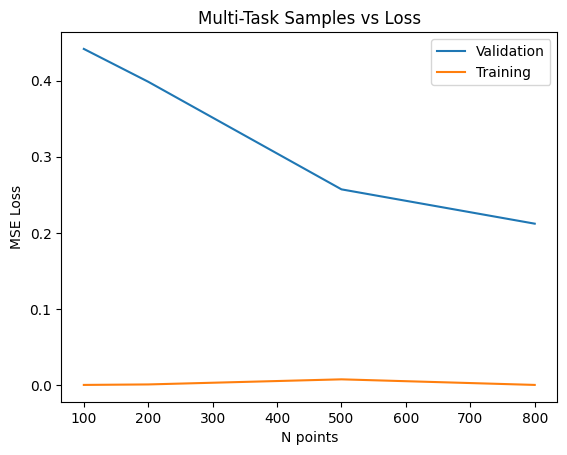

In [17]:
#plot training and validation loss
# Create a line plot
plt.plot(option_n, results["val_loss"], label = "Validation")
plt.plot(option_n, results["train_loss"], label = "Training")

# Add labels and title
plt.xlabel('N points')
plt.ylabel('MSE Loss')
plt.title('Multi-Task Samples vs Loss')
plt.legend()

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


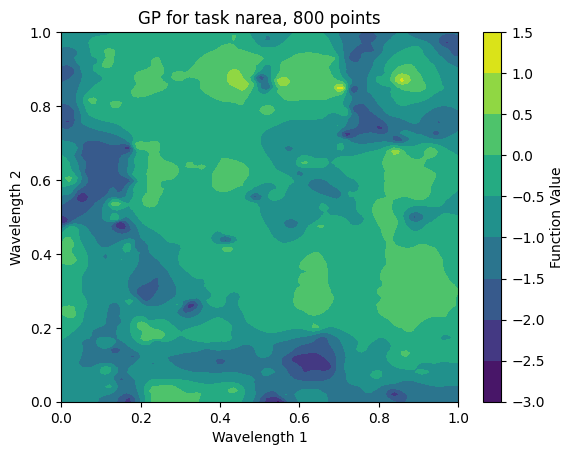

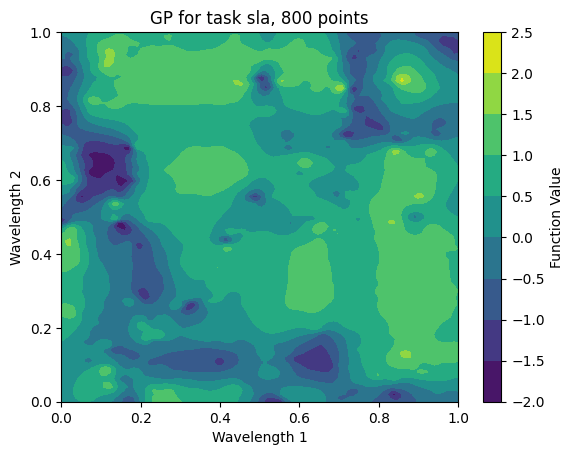

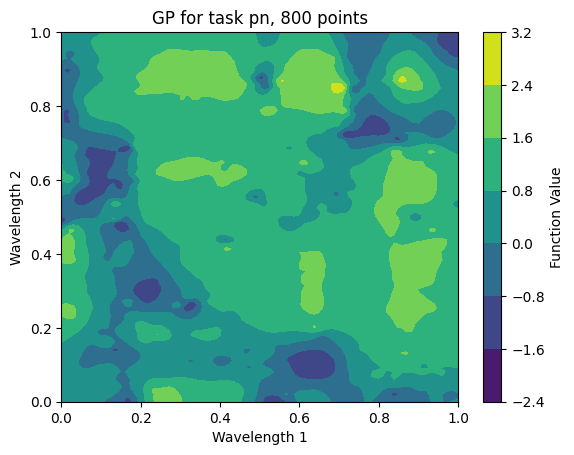

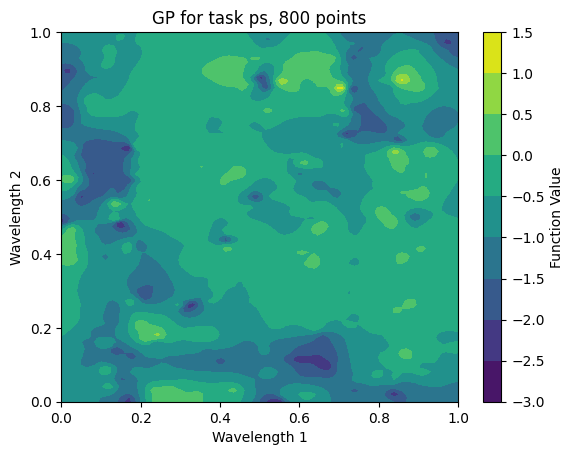

In [18]:
for task in tasks:
  def modelWrapper(X):
    id = getTaskID(task)
    id_vector = id * torch.ones((X.shape[0],1))
    inp = torch.cat([X, id_vector], dim=1)
    return model.posterior(inp).mean

  surfacePlot(modelWrapper, title=f"GP for task {task}, {option_n[-1]} points", n=100)

In [19]:
# #Save kernel
# #This kernels is for inputs with nxdim, where each row is [[0-2150], [0,2150], taskid]
# if not smoke_test:
#   #save mixed kernel
#   torch.save(model.covar_module, f'{base_path}/kernel/mixedKernel.csv')

#   #check that it loads
#   temp = torch.load(f'{base_path}/kernel/mixedKernel.csv')

In [20]:
# #load model and results, requires inputting data
# model_N = option_n[-1] # num training data in desired model

# #re-load model here
# state_dict = torch.load(f'{base_path}/models/vanilla_gp_mixed_{model_N}.pth')
# x_train_normalized, y_train_standardized = mergeData(train_data.values(), N=10)
# model = MixedSingleTaskGP(x_train_normalized[:model_N], y_train_standardized[:model_N], cat_dims=[-1])  # Create a new GP model
# model.load_state_dict(state_dict)

# #re-load your results
# with open(f'{base_path}/results/vanillaGP_mixed.pkl', 'rb') as pickle_file:
#     results = pickle.load(pickle_file)

In [21]:
# #plot training and validation loss
# for task in tasks:
#   task_dic = results[task]

#   # Create a line plot
#   plt.plot(option_n, task_dic["val_loss"], label = f"{task} val_loss", linestyle="--")
#   plt.plot(option_n, task_dic["train_loss"], label = f"{task} train_loss", linestyle="solid")

# # Add labels and title
# plt.xlabel('N points')
# plt.ylabel('MSE Loss')
# plt.title('Samples vs Loss')
# plt.legend()

# # Show the plot
# plt.show()

In [22]:
# #load model and results, requires inputting data
# model_N = option_n[-1] # num training data in desired model

# # #re-load model here
# # state_dict = torch.load(f'{base_path}/models/vanilla_gp_mixed_{model_N}.pth')
# # x_train_normalized, y_train_standardized = mergeData(train_data.values(), N=10)
# # model = MixedSingleTaskGP(x_train_normalized[:model_N], y_train_standardized[:model_N], cat_dims=[-1])  # Create a new GP model
# # model.load_state_dict(state_dict)

# for task in tasks:
#   def modelWrapper(X):
#     id = getTaskID(task)
#     id_vector = id * torch.ones((X.shape[0],1))
#     inp = torch.cat([X, id_vector], dim=1)
#     return model.posterior(inp).mean

#   surfacePlot(modelWrapper, title=f"GP for task {task}, {model_N} points", n=100)

In [23]:
#Make a barplot here...

#single task test,
#single task train
#single task test
#single task test

#should technically have varience plot(s)